UPDATE:
- ADD MORE DATA AUGMENTATION
- ADD EARLY STOPPING
- ADD SCHEDULER TO ADJUST LEARNING RATE DURING TRAINING



In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [2]:
import os
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


class PneumoniaDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.image_paths = []
    self.labels = []

    for class_name in os.listdir(root_dir):
      class_dir = os.path.join(root_dir, class_name)
      for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        self.image_paths.append(image_path)
        self.labels.append(0 if (class_name == "NORMAL") else 1)

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image = Image.open(self.image_paths[idx]).convert("RGB")
    if self.transform:
      image = self.transform(image)

    label = self.labels[idx]

    return image, label



def train_model(num_epochs, model, train_loader, val_loader,
                criterion, optimizer, device, patience=None, lr_scheduler=False):
  # !!! MAKE SURE THE MODEL IS IN THE GIVEN DEVICE
  model = model.to(device)
  best_loss = torch.inf

  epochs_no_improve = 0

  scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',        # minimize val_loss
        factor=0.1,        # reduce LR by 10x
        patience=2,        # wait 2 epochs before reducing
        threshold=1e-4,    # consider improvement significant if >0.0001
        cooldown=1,        # wait 1 epoch after LR reduction before resuming
        min_lr=1e-7,       # lower bound for LR
    )

  train_figure = {
      "train_loss": [],
      "val_loss": [],
      "val_acc": [],
  }

  for epoch in range(num_epochs):

    total_train_loss = 0
    total_val_loss = 0

    # -------------------- TRAINING -------------------------------
    model.train()
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()

      outputs = model(images)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      total_train_loss += loss.item()

    train_loss = total_train_loss / len(train_loader)
    train_figure["train_loss"].append(train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"train_loss: {train_loss:.4f}")

    # -------------------- VALIDATION -------------------------------
    val_preds = []
    val_labels = []
    model.eval()
    with torch.no_grad():
      for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)

        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

        total_val_loss += loss.item()

      val_loss = total_val_loss / len(val_loader)
      train_figure["val_loss"].append(val_loss)

      val_acc = accuracy_score(val_preds, val_labels)
      train_figure["val_acc"].append(val_acc)

      print(f"val_loss: {val_loss:.4f}, val_accuracy: {val_acc:.4f}")

      if lr_scheduler:
        scheduler.step(val_loss)


      # -------------------- EARLY STOPPING -------------------------------
      if patience:
        # Early stopping
        if val_loss < best_loss:
          best_loss = val_loss
          epochs_no_improve = 0
          torch.save(model.state_dict(), "best_resnet50_model.pth")
          print(f"Best model saved at Epoch {epoch+1}")
          print(f"Patience: 0/{patience}")
        else:
          epochs_no_improve += 1
          print(f"No reduction in val_loss {val_loss:.4f} > {best_loss:.4f}")
          print(f"Patience: {epochs_no_improve}/{patience}")
          if epochs_no_improve >= patience:
            print("Early stopping triggered at Epoch ", epoch+1)
            print("Best val loss: ", best_loss)
            break
      else:
        # No early stopping, save the best model (min val_loss)
        if val_loss < best_loss:
          torch.save(model.state_dict(), "best_resnet50_model.pth")
          print(f"Best model saved at Epoch {epoch+1}")

    print(" ")



  return train_figure

cuda


In [3]:
# Add more train transform: ColorJitter, Blur, Random_Erasing
train_transfrom = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5), # 50% of images are flipped
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = PneumoniaDataset(root_dir="/kaggle/input/chest-xray-pneumonia/chest_xray/train", transform=train_transfrom)
test_dataset = PneumoniaDataset(root_dir="/kaggle/input/chest-xray-pneumonia/chest_xray/test", transform=val_test_transforms)
val_dataset = PneumoniaDataset(root_dir="/kaggle/input/chest-xray-pneumonia/chest_xray/val", transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [4]:
def create_resnet50_model(num_class, frezze=False):
  model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

  if frezze:
    # Freeze all layers
    for param in model.parameters():
      param.requires_grad = False

    # Replace the Fully Connected layers
    model.fc = nn.Linear(model.fc.in_features, num_class)

    # Unfreeze the last residual block (layer4) and the new fc layer
    for name, param in model.named_parameters():
      if "layer4" in name or "fc" in name:
        param.requires_grad = True

  else:
    # No freezing, all layers are trainable
    model.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(model.fc.in_features, num_class)
        )

  return model


model = create_resnet50_model(num_class=2, frezze=False)
model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s]


In [ ]:
figure = train_model(
    num_epochs=25,
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1),
    optimizer= optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4),
    device=device,
    patience=5,
    lr_scheduler=True,
)

print(figure)

Epoch 1/25
train_loss: 0.3424
val_loss: 0.5852, val_accuracy: 0.7917
Best model saved at Epoch 1
Patience: 0/5
 
Epoch 2/25
train_loss: 0.2572
val_loss: 0.3718, val_accuracy: 0.8974
Best model saved at Epoch 2
Patience: 0/5
 
Epoch 3/25
train_loss: 0.2440
val_loss: 0.3330, val_accuracy: 0.9263
Best model saved at Epoch 3
Patience: 0/5
 
Epoch 4/25
train_loss: 0.2454
val_loss: 0.3348, val_accuracy: 0.9359
No reduction in val_loss 0.3348 > 0.3330
Patience: 1/5
 
Epoch 5/25
train_loss: 0.2309
val_loss: 0.3128, val_accuracy: 0.9279
Best model saved at Epoch 5
Patience: 0/5
 
Epoch 6/25
train_loss: 0.2271
val_loss: 0.3407, val_accuracy: 0.9247
No reduction in val_loss 0.3407 > 0.3128
Patience: 1/5
 
Epoch 7/25
train_loss: 0.2293
val_loss: 0.4609, val_accuracy: 0.8718
No reduction in val_loss 0.4609 > 0.3128
Patience: 2/5
 
Epoch 8/25
train_loss: 0.2270
val_loss: 0.3653, val_accuracy: 0.9135
No reduction in val_loss 0.3653 > 0.3128
Patience: 3/5
 
Epoch 9/25
train_loss: 0.2178
val_loss: 0.38

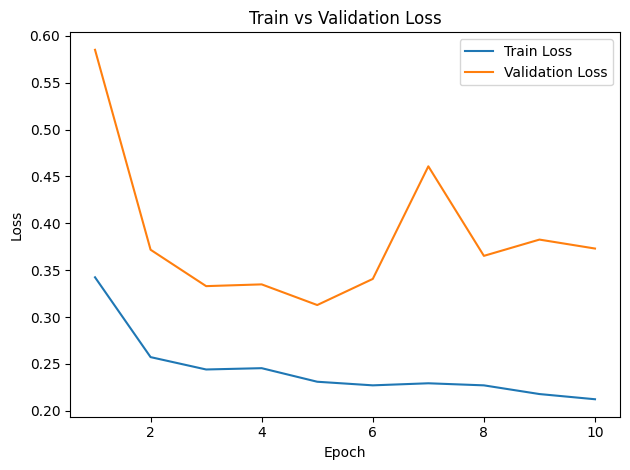

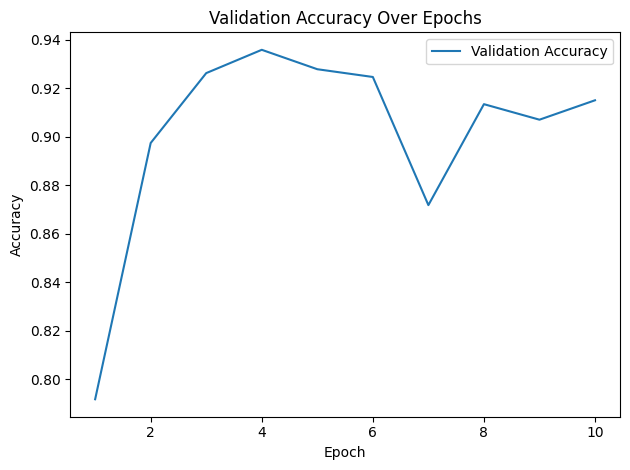

In [5]:
import matplotlib.pyplot as plt

data = {
    'train_loss': [0.3423796839143601, 0.25718355846185625, 0.24398470537428477, 0.24538055309123058, 0.2308993191441144, 0.22705648208688373, 0.22925434759789448, 0.22704589997698194, 0.2177608876140571, 0.212210931752357],
    'val_loss': [0.5852141812443733, 0.37180637940764427, 0.33295961916446687, 0.3348257981240749, 0.3127748355269432, 0.34065733253955843, 0.46085711792111395, 0.36526680588722227, 0.38263522908091546, 0.37308157458901403],
    'val_acc': [0.7916666666666666, 0.8974358974358975, 0.9262820512820513, 0.9358974358974359, 0.9278846153846154, 0.9246794871794872, 0.8717948717948718, 0.9134615384615384, 0.907051282051282, 0.9150641025641025]
}

epochs = list(range(1, len(data['train_loss']) + 1))

# Loss comparison plot
plt.figure()
plt.plot(epochs, data['train_loss'], label="Train Loss")
plt.plot(epochs, data['val_loss'], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Accuracy plot
plt.figure()
plt.plot(epochs, data['val_acc'], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
def evaluate_model(val_loader, model, class_name, matrix=False):

  from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
  model.eval()

  val_preds = []
  val_labels = []
  with torch.no_grad():
    for images, labels in val_loader:
      outputs = model(images)
      _, preds = torch.max(outputs, dim=1)

      val_preds.extend(preds.cpu().numpy())
      val_labels.extend(labels.cpu().numpy())

    if matrix:
      cm = confusion_matrix(val_labels, val_preds)

      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_name)
      disp.plot(cmap="Blues", xticks_rotation=45)
      plt.title("Confusion Matrix")
      plt.show()


  return accuracy_score(val_preds, val_labels)

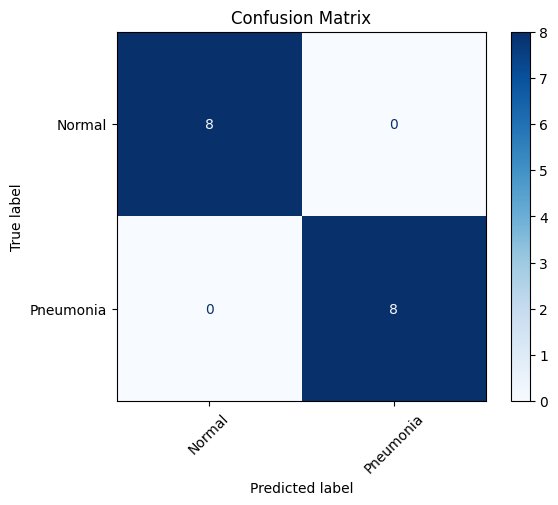

1.0

In [7]:
best_model = create_resnet50_model(num_class=2, frezze=False)
best_model.load_state_dict(torch.load("/content/best_resnet50_model_updated.pth", map_location=device))

evaluate_model(val_loader, best_model, matrix=True, class_name=["Normal", "Pneumonia"])

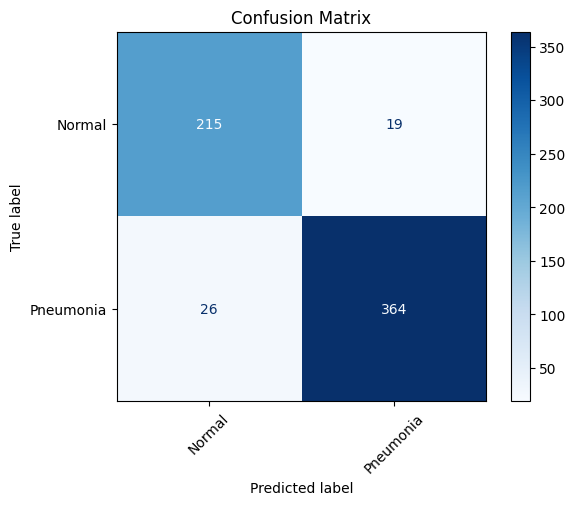

0.9278846153846154

In [8]:
evaluate_model(test_loader, best_model, matrix=True, class_name=["Normal", "Pneumonia"])